## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
!pip install -U datasets

In [8]:
from datasets import load_dataset
dataset = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [10]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [14]:
def get_tweet(data):
   tweets = [x['text'] for x in data]
   labels = [x['label'] for x in data]
   return tweets, labels


In [15]:
tweets, labels = get_tweet(train)

In [18]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [20]:
tokenizer = Tokenizer(num_words = 10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

In [21]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

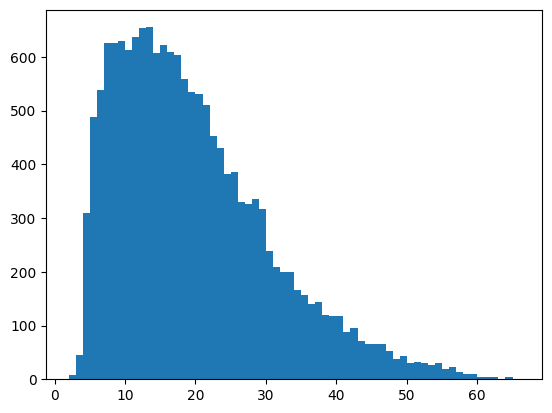

In [22]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [23]:
maxlen= 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', maxlen = maxlen)
  return padded

In [25]:
padde_train = get_sequences(tokenizer, tweets)
padde_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   2, 139,   3, 679], dtype=int32)

In [27]:
padde_train[0].shape

(50,)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [28]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


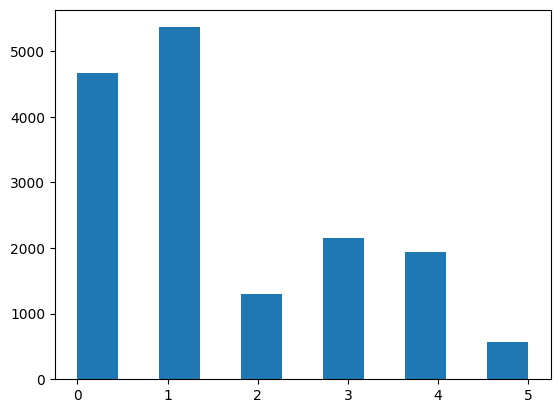

In [34]:
plt.hist(labels, bins = 11)
plt.show()

In [35]:
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [36]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [38]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [39]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [40]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [48]:
t = tf.keras.layers
model = tf.keras.models.Sequential([
    t.Embedding(10000,16, input_length= maxlen),
    t.Bidirectional(t.LSTM(20,return_sequences = True )),
    t.Bidirectional(t.LSTM(20)),
    t.Dense(6, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer ='adam',
    metrics =['accuracy']
)

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [50]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [51]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [52]:
h = model.fit(
    padde_train, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 47s 71ms/step - loss: 1.3310 - accuracy: 0.4538 - val_loss: 0.9235 - val_accuracy: 0.6480
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.5752 - accuracy: 0.8012 - val_loss: 0.5965 - val_accuracy: 0.8000
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3719 - accuracy: 0.8738 - val_loss: 0.4854 - val_accuracy: 0.8360
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2591 - accuracy: 0.9191 - val_loss: 0.4823 - val_accuracy: 0.8540
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1887 - accuracy: 0.9442 - val_loss: 0.4947 - val_accuracy: 0.8565
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.1584 - accuracy: 0.9520 - val_loss: 0.4605 - val_accuracy: 0.8675
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1417 - accuracy: 0.9571 - val_loss: 0.4276 - val_accuracy: 0.

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

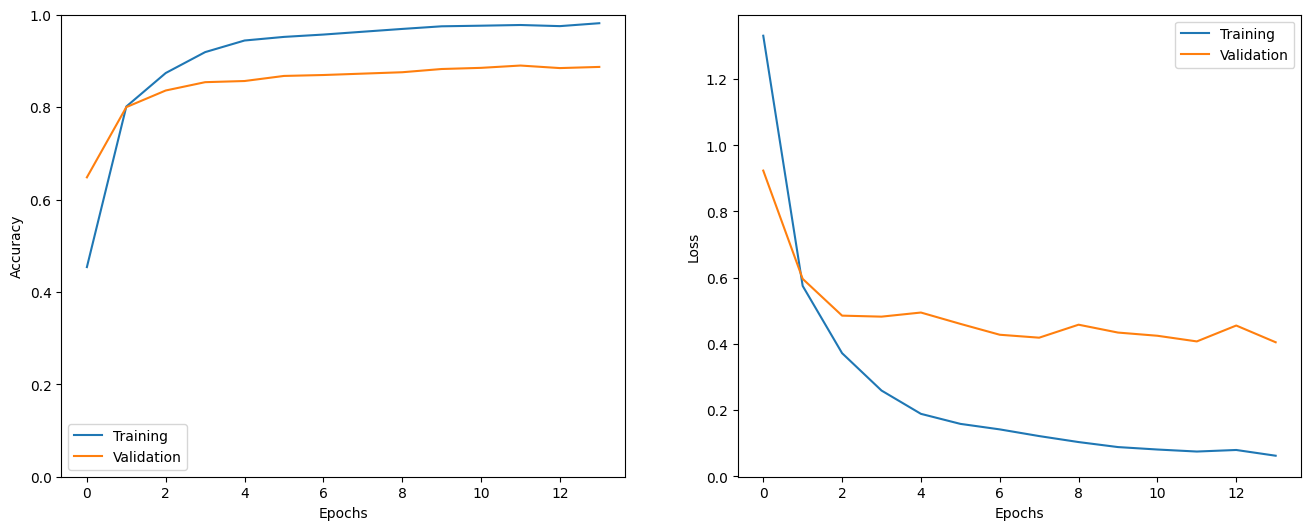

In [53]:
show_history(h)

In [55]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [57]:
_= model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 11ms/step - loss: 0.4241 - accuracy: 0.8835


In [60]:
i = random.randint(0, len(test_labels -1))
print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pre_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted emotion: ', pre_class)

Sentence:  i must confess that im still feeling very uncertain about how god is going to work everything out
Emotion:  4
1/1 [==============================] - 0s 26ms/step
Predicted emotion:  4


In [61]:
preds = model.predict(test_seq)

63/63 [==============================] - 1s 10ms/step


In [62]:
show_confusion_matrix(test_labels, preds, list(classes))

ValueError: ignored

In [1]:
p = tf.keras.layers.Embedding(10000, 32, input_length = 50)

NameError: ignored

In [65]:
print(len(p))

3
